# This notebook reproduces Fig. 3 of xxxx.xxxxx

### - Start importing libraries

In [1]:
# Global
import jax.numpy as jnp
import numpy as np
import corner
import matplotlib.pyplot as plt


# Local
import examples_utils as eu
import fastPTA.utils as ut
from fastPTA.plotting_functions import my_colormap
from fastPTA.Fisher_code import compute_fisher
from fastPTA.signals import get_signal_model

### - Constants to be used in the analysis

In [2]:
# Total observation time in years
T_obs_yrs = 10

# Number of frequencies used in the analysis
n_frequencies = 100

# Number of pulsars in the analysis
n_pulsars_1 = 100
n_pulsars_2 = 400

# Specify the type of noise to be used in the analysis
which_experiment = eu.mockSKA10

# Set the label to specify the signal model
signal_label = "power_law_SIGW"

# Current SMBBH SGWB best-fit paramteres
SMBBH_log_amplitude = -7.1995
SMBBH_tilt = 2

# The analysis assumes a SIGW template, specify here the input parameters
SIGW_log_amplitude = -1.7
SIGW_log_width = np.log10(0.5)
SIGW_log_pivot = -7.8

# Specify the true signal parameters
SMBBH_parameters = jnp.array(
    [SMBBH_log_amplitude, SMBBH_tilt]
)

CGW_SIGW_parameters = jnp.array(
    [SIGW_log_amplitude, SIGW_log_width, SIGW_log_pivot]
)

signal_parameters = np.concatenate(
    [SMBBH_parameters, CGW_SIGW_parameters]
)

# Specify the labels for the signal parameters
parameter_labels = []

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

# Name of the pulsar catalogue
outname_1 = "pulsar_configurations/SIGW+PL_1.txt"
outname_2 = "pulsar_configurations/SIGW+PL_2.txt"

### - Set the inputs for the Fisher analysis

In [4]:
# Get the signal model
signal_model = get_signal_model(signal_label)
SIGW_part = get_signal_model("SIGW")
PL_part = get_signal_model("power_law")

# Dictionaries with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs_1 = {
    "n_pulsars": n_pulsars_1,
    "save_catalog": False,
    **which_experiment,
}

generate_catalog_kwargs_2 = {
    "n_pulsars": n_pulsars_2,
    "save_catalog": False,
    **which_experiment,
}

# Dictionaries with the kwargs to generate noise and orf tensors
get_tensors_kwargs_1 = {
    "add_curn": False,
    "regenerate_catalog": False,
    "path_to_pulsar_catalog": outname_1,
}

get_tensors_kwargs_2 = {
    "add_curn": False,
    "regenerate_catalog": False,
    "path_to_pulsar_catalog": outname_2,
}

# Dictionary with the kwargs for the Fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
}

### - Compute the Fisher matrix

In [9]:
# Catalog 1

(
    frequency_1,
    signal_1,
    HD_functions_IJ_1,
    HD_coeffs_1,
    effective_noise_1,
    SNR_1,
    fisher_1,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs_1,
    generate_catalog_kwargs=generate_catalog_kwargs_1,
)

covariance_1 = ut.compute_inverse(fisher_1)
fisher_data_1 = np.random.multivariate_normal(
    signal_parameters, covariance_1, size=len_fisher_data
)
errors_1 = np.sqrt(np.diag(covariance_1))
print(f"Fisher errors for {n_pulsars_1} pulsars: {errors_1}")

# Catalog 2

(
    frequency_2,
    signal_2,
    HD_functions_IJ_2,
    HD_coeffs_2,
    effective_noise_2,
    SNR_2,
    fisher_2,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs_2,
    generate_catalog_kwargs=generate_catalog_kwargs_2,
)

covariance_2 = ut.compute_inverse(fisher_2)
fisher_data_2 = np.random.multivariate_normal(
    signal_parameters, covariance_2, size=len_fisher_data
)

errors_2 = np.sqrt(np.diag(covariance_2))
print(f"Fisher errors for {n_pulsars_2} pulsars: {errors_2}")

Fisher errors for 100 pulsars: [0.03059667 0.10693611 0.35462343 0.34378827 0.22836145]
Fisher errors for 400 pulsars: [0.01660557 0.05769549 0.18954513 0.18398614 0.12236727]


### - Corner plot

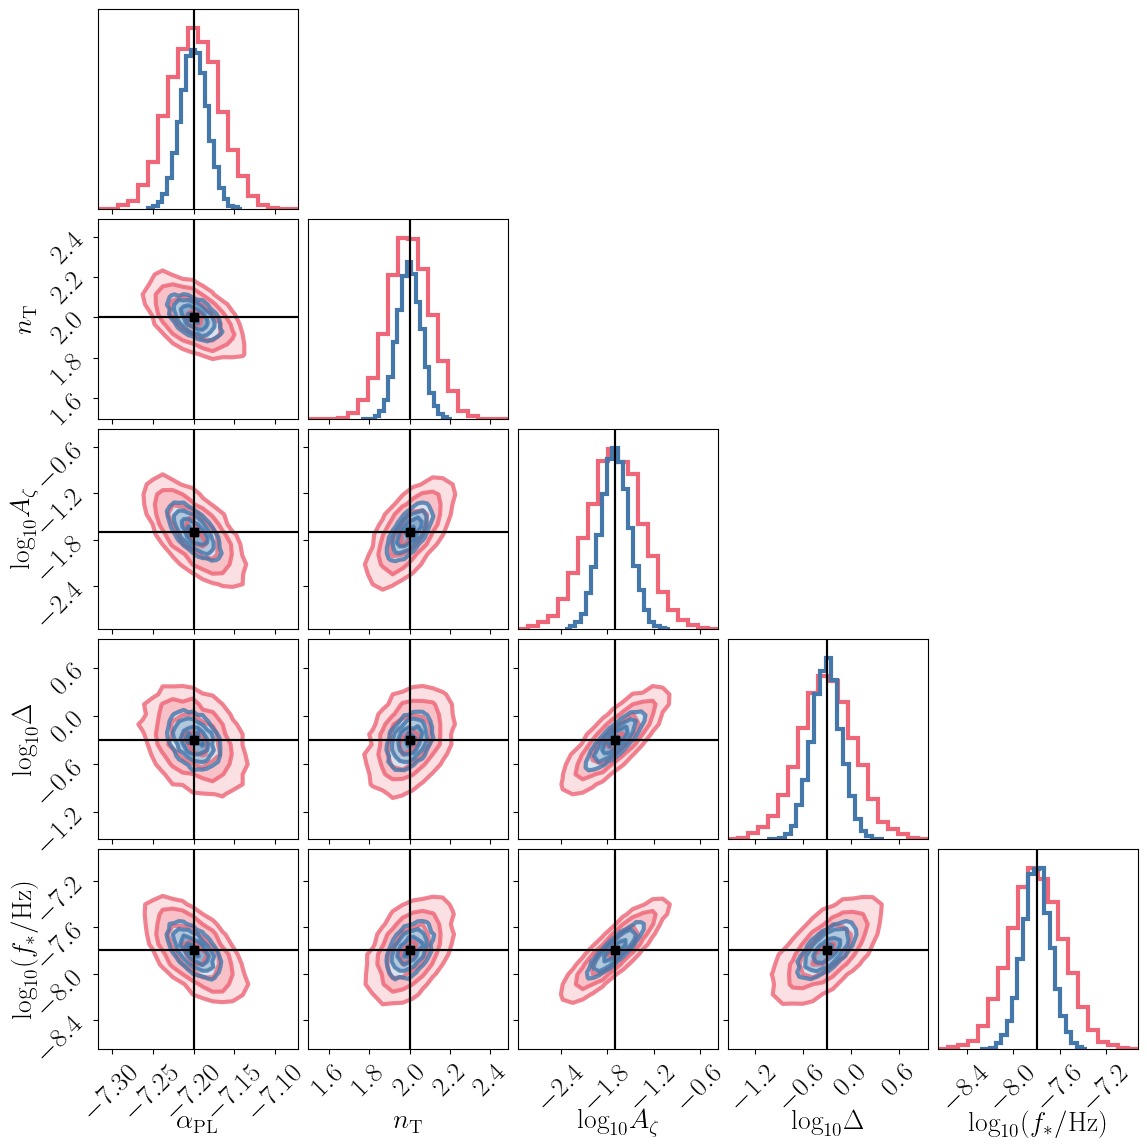

In [6]:
if not parameter_labels:
    parameter_labels = signal_model.parameter_labels

title_size = 10
widthlines_cont = 3
alpha_v = 0.8

figure = corner.corner(
    fisher_data_1,
    labels=parameter_labels,
    truths=signal_parameters,
    plot_datapoints=False,
    fill_contours=True,
    plot_contours=True,
    title_kwargs={"fontsize": title_size, "pad": 20},
    contour_kwargs={"linewidths": widthlines_cont, "alpha": alpha_v},
    hist_kwargs={"linewidth": widthlines_cont},
    color=my_colormap["red"],
    truth_color="black",
)

corner.corner(
    fisher_data_2,
    fig=figure,
    truths=signal_parameters,
    plot_datapoints=False,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"linewidths": widthlines_cont, "alpha": alpha_v},
    hist_kwargs={"linewidth": widthlines_cont},
    color=my_colormap["blue"],
    truth_color="black",
)
    
plt.show(block=True)


### - Plot the spectrum and the effective sensitivity

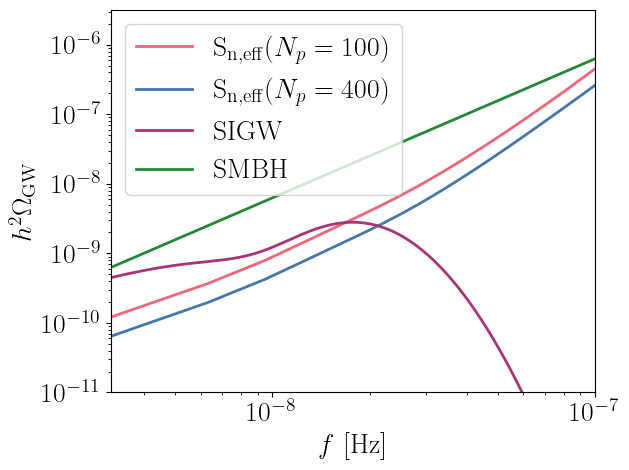

In [7]:
x = np.logspace(np.log10(1 / 10 / ut.yr), -7, 500)
y = SIGW_part.template(x, CGW_SIGW_parameters) #SIGW contribution
yPL = PL_part.template(x, SMBBH_parameters) #PL contribution

plt.loglog(
    frequency_1,
    effective_noise_1,
    label=r"${\rm S_{n,{\rm eff}}}(N_p = 100)$",
    color=my_colormap["red"],
    linewidth=2,
)
plt.loglog(
    frequency_2,
    effective_noise_2,
    label=r"${\rm S_{n,{\rm eff}}}(N_p = 400)$",
    color=my_colormap["blue"],
    linewidth=2,
)
plt.loglog(x, y, label=r"${\rm SIGW}$", color=my_colormap["purple"], linewidth=2)
plt.loglog(x, yPL, label=r"${\rm SMBH}$", color=my_colormap["green"], linewidth=2)

plt.xlabel(r"$f \ [{\rm Hz}]$")
plt.ylabel(r"$h^2 \Omega_{\rm GW}$")
plt.xlim(1 / 10 / ut.yr, 1e-7)
plt.ylim(1e-11, 10**-5.5)
plt.legend(loc=2, ncols=1)
plt.tight_layout()
plt.show(block=True)